In [1]:
import numpy as np
from dualtime.src.mclachlan import VarQITE
from gibbs.utils import create_hamiltonian_lattice,printarray,expected_state,state_from_ansatz, simple_purify_hamiltonian,expected_state, create_heisenberg
from gibbs.preparation.varqite import brute_force_optimization, pauli_rotations_ansatz
from gibbs.preparation.free_energy import brute_cmaes
from qiskit.circuit import ClassicalRegister
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp,Statevector, state_fidelity, DensityMatrix
from gibbs.learning.hamiltonian_learning import HamiltonianLearning
from scipy.linalg import expm, logm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

SparsePauliOp(['ZZIIIII', 'IZZIIII', 'IIZZIII', 'IIIZZII', 'IIIIZZI', 'IIIIIZZ', 'XIIIIII', 'IXIIIII', 'IIXIIII', 'IIIXIII', 'IIIIXII', 'IIIIIXI', 'IIIIIIX'],
              coeffs=[ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
 -1.  +0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j,
 -1.  +0.j])


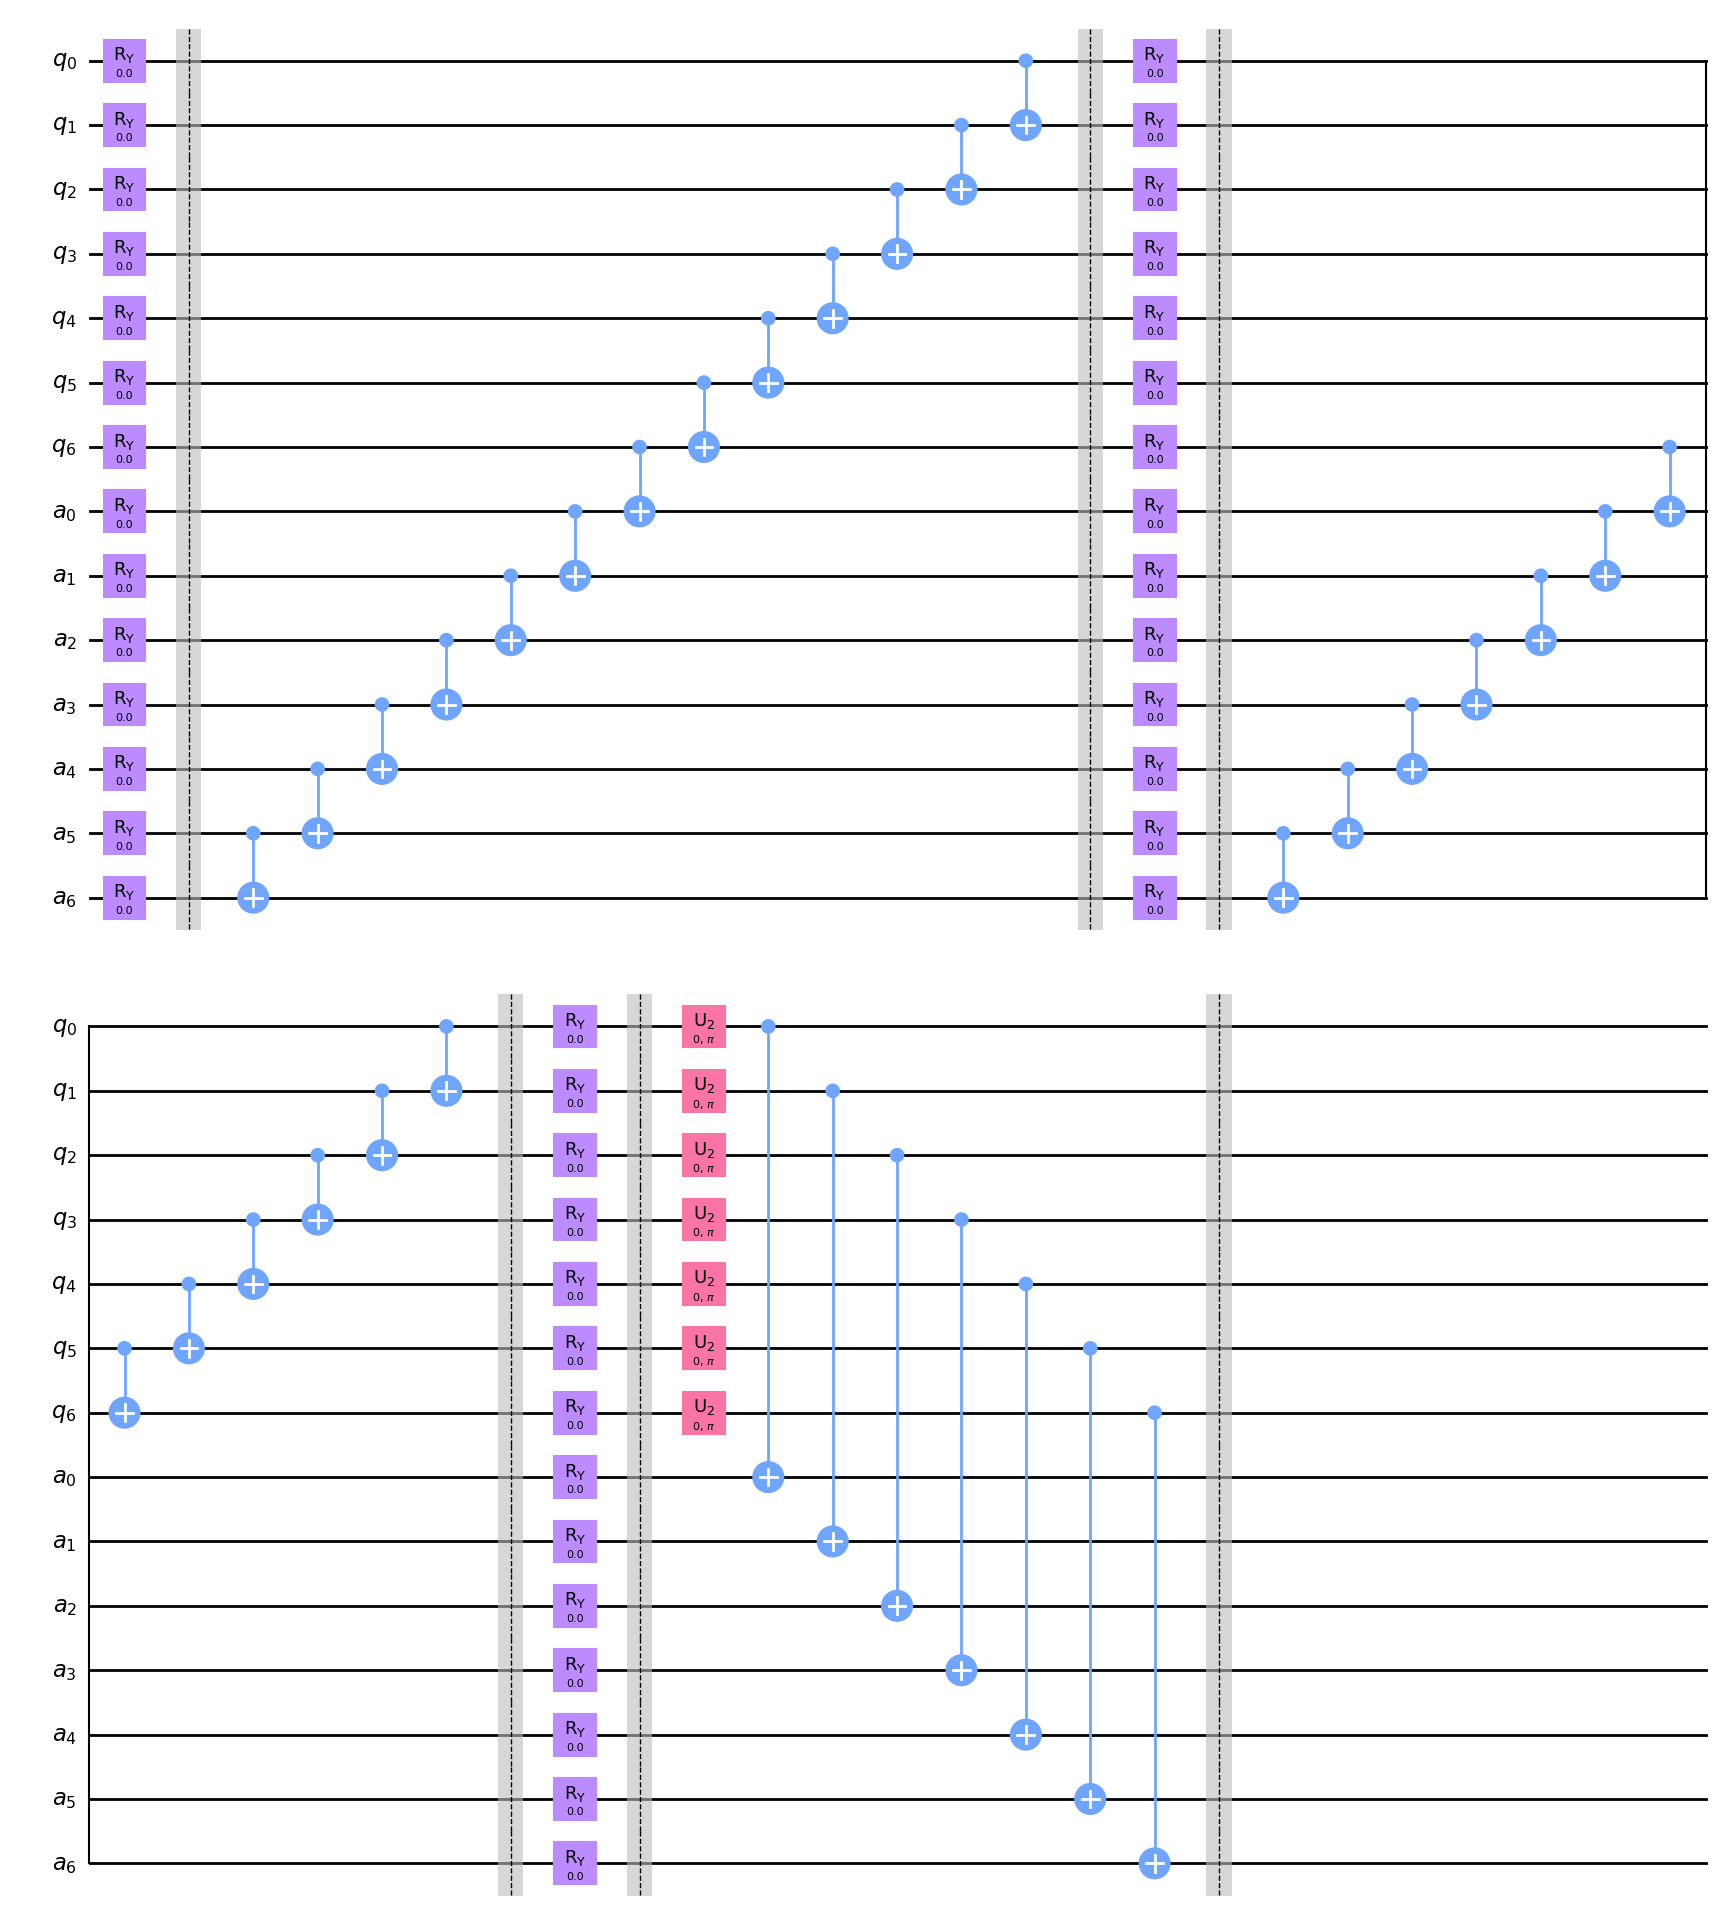

0
0.125
0.25
0.375
We have gotten a gibbs state with fidelity: 0.9921710490824279
With respect to the fidelity with the initial state: 0.25022372163366513


In [2]:
beta = 1
# hamiltonian = create_heisenberg(3,1/4,-1,False)
hamiltonian = create_hamiltonian_lattice(7,1/4,-1) #This one is giving good results with ry rotations and cx reverse_linear entanglement
print(hamiltonian)
N = hamiltonian.num_qubits
entanglement = [None]*2*N
entanglement[::2]=[(i,i+N) for i in range(N)]
entanglement[1::2]=[(i+N,i+1) for i in range(N)]
rotations = []
ansatz,x0 = pauli_rotations_ansatz(hamiltonian,depth = 2,entanglement="reverse_linear",rotations=rotations,su2_gates=["ry"],ent_gates=["cx"])
x0 = np.zeros_like(x0)
varqite = VarQITE(ansatz,x0,backend=None)
steps = 4
result_varqite = varqite.evolve(PauliSumOp(hamiltonian^("I"*N)),beta/2,timestep = beta/(2*steps))
final_state = state_from_ansatz(ansatz,result_varqite.parameters[-1])
theoretical_state = expected_state(hamiltonian,beta = beta)
print("We have gotten a gibbs state with fidelity:",state_fidelity(final_state,theoretical_state))
print("With respect to the fidelity with the initial state:",state_fidelity(theoretical_state,expected_state(hamiltonian,beta = 0)))
display(ansatz.decompose().bind_parameters(regularized_parameters).draw(output="mpl"))

0.31438539194095383


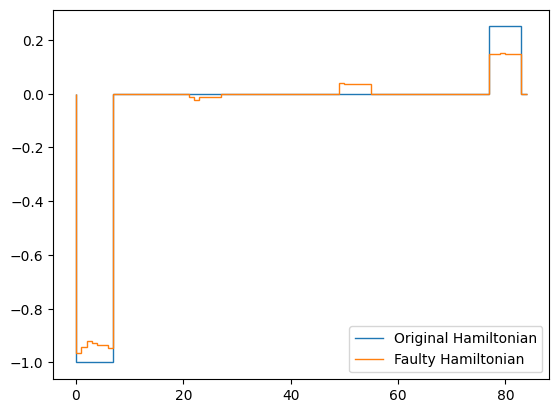

In [11]:
regularized_parameters = result_varqite.parameters[-1].copy()
regularized_parameters[np.abs(regularized_parameters)<1e-8] = 0 
state = ansatz.bind_parameters(result_varqite.parameters[-1])
hl = HamiltonianLearning(state,2,3,periodic=True)    
perfect_reconstruction = hl.classical_learn_hamiltonian()
original_vector = hl.learning_basis.pauli_to_vector(hamiltonian)
plt.stairs(original_vector,label="Original Hamiltonian")
plt.stairs(perfect_reconstruction,label="Faulty Hamiltonian")
plt.legend(loc='lower right')
print(np.linalg.norm(original_vector-perfect_reconstruction))

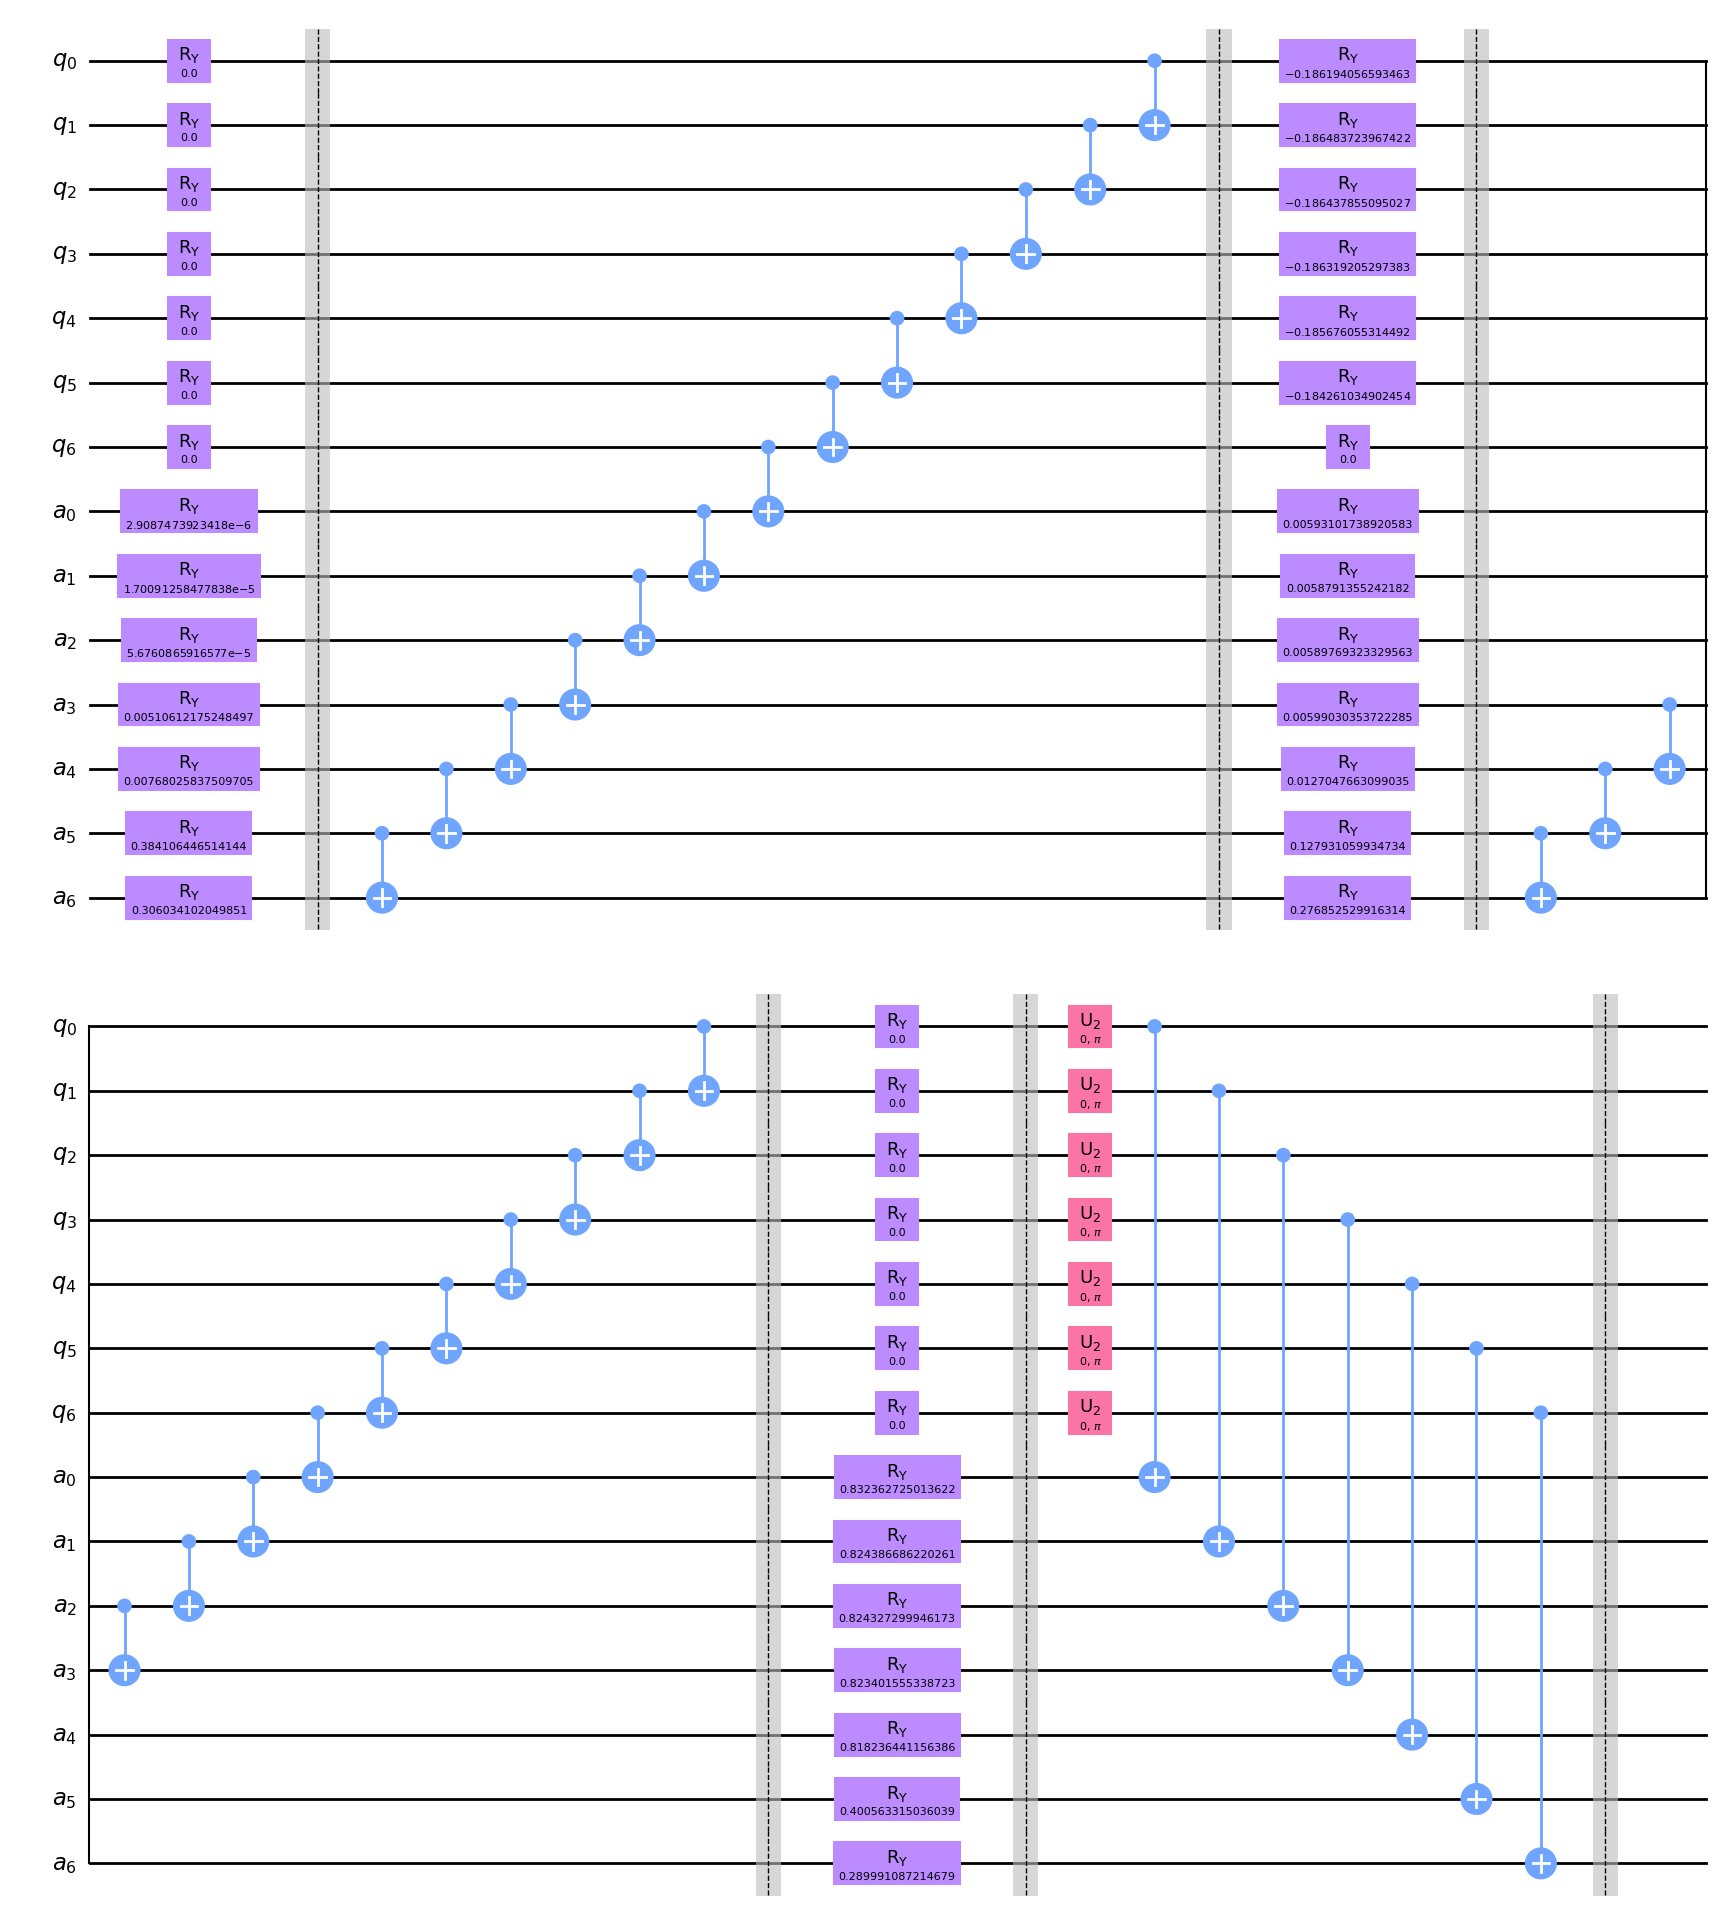

In [5]:
from surfer.gradient import ReverseGradient
gradient = ReverseGradient(do_checks=False)
parameters = x0
hamiltonian_paulis_gradients =[np.linalg.norm(gradient.compute(op^("I"*N),ansatz,parameters)) for op in hamiltonian.paulis]

printarray(hamiltonian_paulis_gradients)
operator = SparsePauliOp.from_list([("YYII",1)])
evolution_gradient_op = [np.linalg.norm(gradient.compute(operator^("I"*N), ansatz, p)) for p in result_varqite.parameters]
print(evolution_gradient_op)

[1.    1.    1.    1.    1.    1.    1.732 1.414 1.    1.    1.    1.
 1.   ]


QiskitError: 'Operator input dimensions are not equal to statevector subsystem dimensions.'